# Домашнее задание 1.

_Екатерина Волошина_

In [192]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from string import punctuation, digits, ascii_letters
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
import spacy

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR, SVC
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_absolute_error, accuracy_score, classification_report, confusion_matrix

nlp = spacy.load("en_core_web_sm")
stop = stopwords.words('english')

tokenizer = WordPunctTokenizer()

## 0. Подготовка 

In [193]:
df = pd.read_csv('Shoes_Data.csv')

Посмотрим, как в целом устроен датасет:

In [194]:
df.head()

,title,price,rating,total_reviews,product_description,reviews,reviews_rating,Shoe Type
0,CLYMB Outdoor Sports Running Shoes for Mens Boy,₹279.00,2.9 out of 5 stars,2389 ratings,Elevate your style with this classy pair of Ru...,Not happy with product|| It's not as expected....,1.0 out of 5 stars|| 1.0 out of 5 stars|| 3.0 ...,Men
1,Bourge Men's Loire-z126 Running Shoes,₹479.00,3.9 out of 5 stars,11520 ratings,The product will be an excellent pick for you....,Memory cushioning in these shoes is the best f...,5.0 out of 5 stars|| 1.0 out of 5 stars|| 5.0 ...,Men
2,T-Rock Men's Sneaker,₹430.00,3.3 out of 5 stars,1251 ratings,Flaunt with these stylish and unique red casua...,Worth to its amount|| Go for it|| Perfect|| 5 ...,5.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 ...,Men
3,Robbie jones Sneakers Casual Canvas Fabric Col...,₹499.00,4.2 out of 5 stars,3 ratings,Robbie Jones Shoes Are Designed To Keeping In ...,Sup quality|| Good but not expected|| Awesome 👌.!,5.0 out of 5 stars|| 3.0 out of 5 stars|| 5.0 ...,Men
4,Sparx Men's Sd0323g Sneakers,₹499.00,4.2 out of 5 stars,20110 ratings,Sparx is a spectacular range of footwear from ...,Best|| Satisfied!|| Affordable beauty 😘😘😘😘 the...,5.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 ...,Men


Теперь посмотрим, информация какого типа содержится в каждой из колонок:

In [195]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1230 entries, 0 to 1229
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                1230 non-null   object
 1   price                1230 non-null   object
 2   rating               1230 non-null   object
 3   total_reviews        1230 non-null   object
 4   product_description  1230 non-null   object
 5   reviews              1230 non-null   object
 6   reviews_rating       1230 non-null   object
 7   Shoe Type            1230 non-null   object
dtypes: object(8)
memory usage: 77.0+ KB


Как мы видим, в датасете 1230 вхождений.

## Задание 1. Предсказать цену по описанию товара

### 1.1 Анализ данных

Проверим, повторяются ли описания товара, по которым мы будем предсказывать, есть ли пропущенные значения или NaN:

In [196]:
print('Дублей нет.') if df.product_description.nunique() == df.shape[0] else print('Есть дубли.')
print('Нет пропущенных значений.') if df.count().min() == df.shape[0] else print('Есть пропущенные значения.')
print('Нет NaNs.') if df.isnull().values.any() == False else print('Есть NaNs.')

Есть дубли.
Нет пропущенных значений.
Нет NaNs.


Уберем все дупликаты:

In [197]:
df = df.drop_duplicates()

Кроме этого, посмотрим, какие символы встречаются в описаниях продукта:

In [198]:
print('Уникальные символы:', ''.join(set(' '.join(df['product_description'].tolist()))))

Уникальные символы: 5ಮWಖnயளw3ாणबGZൾńK™ೀ/ఇதtసಶತൃറఓஒxछ•ಛബषಂ్ಠಚdఒmगಯீைರவொఎIhட'ഓഅഡ)7ಸ‍–%TമెटஃCനथEఘതजള9(ഉ*Aൊ!लಳധഥl👉ஞि✦=ഗ—యOஹಿ6ഴ್पീ»കృంHలവಫ’గുदಭഹబु❓तbನపVಒउडலy-எదൗൈ4ೃகఈാ.టడേ2YിइXಇథಬూൽకವ°ரஇஆபpSഈMனईോठచऊ1ணमೇaெೌநഞആಉഫೋെற्Qిష‘ದಹദघö8ओఫർ്ലiరऑjశू+ஸLೈஅಲJಈీवఅभअqൂಅfഎౌBढ~ेच0ు?फണecಎंசಾഇയkಣഏೊഒFಞ`ोखहొऔ்_భಧഷഖஷహాುజణृvಪ®«sआrైശഔങಥരसழಜzవപടएuസജनഘ😎ಆಟேoैிDఛNమமஓ🏻ಓಡीऱಕ&Pൺஏध:ഭ●ోధाೆేൻकചఆॉ ళஜUംಗ"ுనशஙgयೂഊஉಘRಏతಐூோಷఉ


Как мы видим, есть много символов не из латинского алфавита, посмотрим, сколько текстов содержит ненормативные символы:

In [199]:
non_english = 0
non_symbols = []
symbols = digits + ascii_letters + punctuation + '’' + '°' + '–' + ' '
for i in df.iterrows():
    description = set(i[1][4])
    diff = description.difference(symbols)
    if diff != set():
        non_english += 1
        non_symbols.extend(list(diff))

In [200]:
print(f'Количество текстов со странными символами: {non_english/df.shape[0] * 100}')

Количество текстов со странными символами: 6.403940886699508


Как мы видим, это достаточно маленький процент, поэтому мы уберем такие символы из текстов: 

In [201]:
def clean_text(text):
    for i in non_symbols:
        text = text.replace(i, '')
    return text

In [202]:
non_symbols = set(non_symbols).difference(symbols)
df['product_description'] = df['product_description'].apply(clean_text)
df = df[df['product_description'] != ' ']

Теперь посмотрим на распределение таргетной переменной, то есть цены обуви:

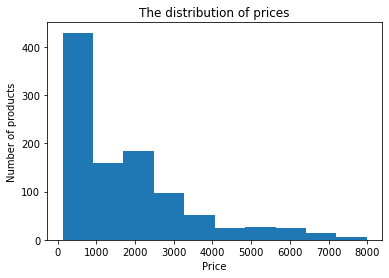

In [203]:
df['price'] = df['price'].str.replace('₹', '').astype(float)
plt.hist(df['price'])
plt.xlabel('Price')
plt.ylabel('Number of products')
plt.title('The distribution of prices')
plt.show()

Посмотрим на то, как устроены описания, например, по длине:

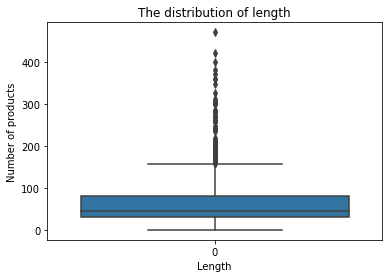

In [204]:
sns.boxplot(data=df['product_description'].str.split().str.len())
plt.xlabel('Length')
plt.ylabel('Number of products')
plt.title('The distribution of length')
plt.show()

Как мы видим, здесь много аутлайнеров. Мы можем посчитать корреляцию между длиной текста и ценой, чтобы посмотреть, стоит ли включать ее как признак:

In [205]:
df_for_corr = df[['price', 'product_description']]
df_for_corr['product_description'] = df_for_corr['product_description'].str.split().str.len()
df_for_corr.corr()

,price,product_description
price,1.000000,0.122381
product_description,0.122381,1.000000


Корреляция достаточно небольшая, поэтому мы будем рассматривать только данные текста в качестве эмбеддингов.

### 1.2 Препроцессинг данных

Прежде чем приступить к преобразованию в вектор, уберем все стоп-слова, пунктуацию и приведем все к начальной форме. Пунктуация в описаниях и текстах достаточно нерегулярная, вероятно, основные различия будут в прилагательных или других словах самостоятельных частей речи (например, "прекрасное качество", "хорошая обувь"), служебные слова будут встречаться во всех отзывах и только мешать анализу. Лучше анализировать однокоренные слова как одно, чтобы мы получили больше информации о его значении и вкладе в конечный результат модели (так как будет одним входом, а не тремя в зависимости от формы, тем более нам не нужна здесь грамматическая информация).

In [206]:
def preprocessing(text):
    text = text.lower()
    text = nlp(text)
    lemmas = [word.lemma_ for word in text if word.text not in punctuation and word.lemma_ not in stop]
    return ' '.join(lemmas)

In [207]:
price_df = df[['title', 'price', 'product_description']]
price_df['lemmas'] = price_df['product_description'].apply(preprocessing)

Посмотрим на получившийся датасет:

In [208]:
price_df

,title,price,product_description,lemmas
0,CLYMB Outdoor Sports Running Shoes for Mens Boy,279.0,Elevate your style with this classy pair of Ru...,elevate style classy pair run shoe house clymb...
1,Bourge Men's Loire-z126 Running Shoes,479.0,The product will be an excellent pick for you....,product excellent pick ensure easy maintenance
2,T-Rock Men's Sneaker,430.0,Flaunt with these stylish and unique red casua...,flaunt stylish unique red casual shoe per late...
3,Robbie jones Sneakers Casual Canvas Fabric Col...,499.0,Robbie Jones Shoes Are Designed To Keeping In ...,robbie jones shoe design keep mind durability ...
4,Sparx Men's Sd0323g Sneakers,499.0,Sparx is a spectacular range of footwear from ...,sparx spectacular range footwear house relaxo ...
...,...,...,...,...
1193,Nike Men's React Vision Running Shoes,7256.0,The Nike react vision is a STORY of surreal co...,nike react vision story surreal comfort layer ...
1194,Puma Men's B.O.G Limitless Hi Evoknit Sneakers,5822.0,The B.O.G limitless is Puma's key style for th...,b.o.g limitless puma 's key style new season i...
1195,new balance Women's FuelCell Echolucent Runnin...,5362.0,Lead the pack in New Balance’s Echolucent snea...,lead pack new balance ’s echolucent sneaker sn...
1196,Nike Women's WMNS Air Zoom Pegasus 37 Running ...,7480.0,Nike . 5K - .____...,nike 5k .____...


### 1.3 Векторизация

Теперь представим описания товаров в виде векторов с помощью двух методов: Bag-of-Words и TF-IDF

In [209]:
TRAIN, TEST = train_test_split(price_df)

In [210]:
bow_vector = CountVectorizer()
bow_train = bow_vector.fit_transform(TRAIN['lemmas'])
bow_test = bow_vector.transform(TEST['lemmas'])

In [211]:
tf_vector = TfidfVectorizer()
tf_train = tf_vector.fit_transform(TRAIN['lemmas'])
tf_test = tf_vector.transform(TEST['lemmas'])

In [212]:
y_train = TRAIN['price']
y_test = TEST['price']

### 1.4 Гридсерч

Теперь с помощью метода GridSearch подберем лучшие гиперпараметры для каждой из трех моделей: линейной регрессии, RandomForest и SVM. Затем мы сравним лучшие модели между собой, чтобы выбрать ту, которая показывает лучшее качество для каждого векторного представления (BoW и TF-IDF)

In [213]:
def gridsearch(estimator, param, vectors):
    clf = GridSearchCV(estimator, param, scoring='neg_mean_squared_error')
    clf.fit(vectors, y_train)
    print(clf.best_estimator_, clf.best_score_)
    return clf

In [214]:
def compare(*models):
    scores = np.array([clf.best_score_ for clf in models])
    ind = np.argmax(scores)
    return models[ind].best_estimator_

In [215]:
linreg = LinearRegression()
param = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
gr_lr = gridsearch(linreg, param, bow_train)
gr_lr_tf = gridsearch(linreg, param, tf_train)

LinearRegression(fit_intercept=False, normalize=True) -9536920.496256653
LinearRegression(fit_intercept=False, normalize=True) -7660304.166318165


In [216]:
tree = RandomForestRegressor()
param = { "n_estimators"      : [10,20,30],
         "max_features"      : ["auto", "sqrt", "log2"],
         "min_samples_split" : [2,4,8],
         "bootstrap": [True, False],
        }
gr_tree = gridsearch(tree, param, bow_train)
gr_tree_tf = gridsearch(tree, param, tf_train)

RandomForestRegressor(bootstrap=False, max_features='sqrt', min_samples_split=8,
                      n_estimators=20) -1231551.1792633114
RandomForestRegressor(bootstrap=False, max_features='sqrt', min_samples_split=8,
                      n_estimators=30) -1308257.4151771136


In [217]:
svm = SVR()
param = [{'C': [1], 'kernel': ['linear']},
         {'C': [1, 10, 100, 1000], 'kernel': ['rbf']},
         {'C': [1, 10, 100, 1000], 'kernel': ['sigmoid']}]
gr_svm = gridsearch(svm, param, bow_train)
gr_svm_tf = gridsearch(svm, param, tf_train)

SVR(C=1000) -1509637.603329975
SVR(C=1000, kernel='sigmoid') -1387533.8698502635


Запомним лучшие модели:

In [218]:
bow_model = compare(gr_tree, gr_svm, gr_lr)
tf_model = compare(gr_tree_tf, gr_svm_tf, gr_lr_tf)

In [219]:
print('Лучшая модель для BoW:', bow_model)
print('Лучшая модель для TF-IDF:', tf_model)

Лучшая модель для BoW: RandomForestRegressor(bootstrap=False, max_features='sqrt', min_samples_split=8,
                      n_estimators=20)
Лучшая модель для TF-IDF: RandomForestRegressor(bootstrap=False, max_features='sqrt', min_samples_split=8,
                      n_estimators=30)


Вероятно, зависимости в датасете нелинейные, поэтому линейные модели не могут восстановить ее, и лучшей оказывается ансамбль деревьев

### 1.5 Анализ лучших моделей

Для начала посчитаем R2, чтобы посмотреть, как модели объясняют данные:

In [220]:
bow_pred = bow_model.predict(bow_test)
tf_pred = tf_model.predict(tf_test)

print('R2-скор для BoW-векторов равен:', r2_score(y_test, bow_pred))
print('R2-скор для TfIdf-векторов равен:', r2_score(y_test, tf_pred))

R2-скор для BoW-векторов равен: 0.4067018476714701
R2-скор для TfIdf-векторов равен: 0.4180797590739771


Как мы видим, модели не очень хорошо справляются с заданием и объясняют около 40 % дисперсии данных.
Еще мы можем посчитать среднюю абсолютную ошибку:

In [221]:
print('MAE равна', mean_absolute_error(y_test, bow_pred))
print('MAE равна', mean_absolute_error(y_test, tf_pred))

MAE равна 827.2173204675073
MAE равна 826.5806400676888


MAE оказывается достаточно большим при таком разбросе цены, который представлен в датасете. Посмотрим, как отличаются предсказания от данных на графике:

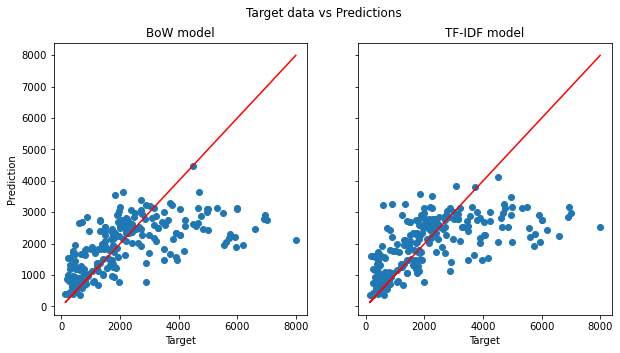

In [222]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
ax[0].scatter(y_test, bow_pred)
ax[0].set_xlabel('Target')
ax[0].set_ylabel('Prediction')
ax[0].set_title('BoW model')
ax[0].plot(y_test, y_test, color='red')
ax[1].scatter(y_test, tf_pred)
ax[1].set_xlabel('Target')
ax[1].set_title('TF-IDF model')
ax[1].plot(y_test, y_test, color='red')
fig.suptitle('Target data vs Predictions')
plt.show()

plt.show()

Как мы видим, в настоящих данных много аутлайнеро больше 4000. Модель, основанная на BoW векторах, не предсказывает значения выше 4000, а модель на TF-IDF векторах делает это, но редко и также не покрывает всех данных

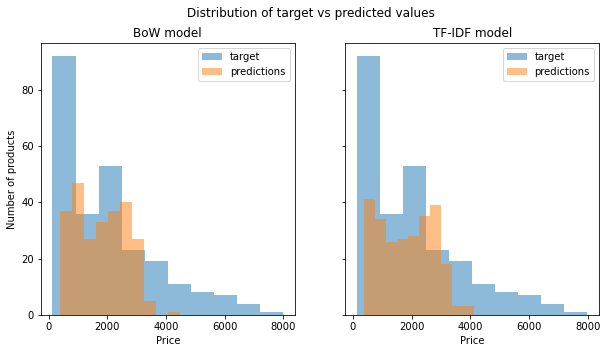

In [223]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
ax[0].hist(y_test, alpha=0.5, label='target')
ax[0].hist(bow_pred, alpha=0.5, label='predictions')
ax[0].legend(loc='upper right')
ax[0].set_xlabel('Price')
ax[0].set_ylabel('Number of products')
ax[0].set_title('BoW model')

ax[1].hist(y_test, alpha=0.5, label='target')
ax[1].hist(tf_pred, alpha=0.5, label='predictions')
ax[1].legend(loc='upper right')
ax[1].set_xlabel('Price')
ax[1].set_title('TF-IDF model')
fig.suptitle('Distribution of target vs predicted values')
plt.show()

График распределения снова показывает, что модели не покрывают большей части данных, потому что в основном предсказывают значения до 4000.

Посмотрим, какие признаки оказались важными для моделей: 

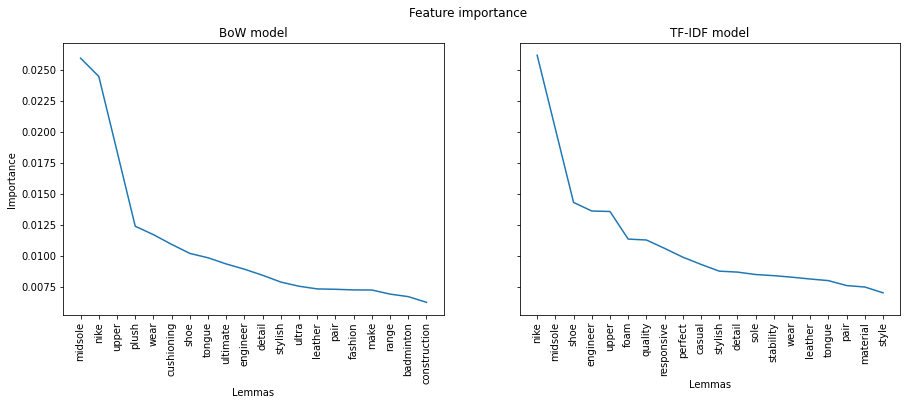

In [224]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
bow_importance = bow_model.feature_importances_
bow_names = np.array(bow_vector.get_feature_names())
ind = np.argsort(bow_importance)[::-1]

tf_importance = tf_model.feature_importances_
tf_names = np.array(tf_vector.get_feature_names())
index = np.argsort(tf_importance)[::-1]

ax[0].plot(bow_names[ind][:20], bow_importance[ind][:20])
ax[0].tick_params(axis='x', rotation=90)
ax[0].set_xlabel('Lemmas')
ax[0].set_ylabel('Importance')
ax[0].set_title('BoW model')
ax[1].plot(tf_names[index][:20], tf_importance[index][:20])
ax[1].tick_params(axis='x', rotation=90)
ax[1].set_xlabel('Lemmas')
ax[1].set_title('TF-IDF model')
fig.suptitle('Feature importance')
plt.show()

Заметим, что несмотря на разницу в значениях, многие слова пересекаются и важны для обеих моделей. Так, на цену влияет, Nike это или нет и сделано ли это из кожи :) 

## Задание 2. Предсказать оценку по отзыву пользователя

### 2.1 Анализ данных

Преобразуем данные так, чтобы в каждой строчке был один отзыв и его оценка:

In [225]:
all_reviews = '|| '.join(df['reviews'].to_list())
all_rates = '|| '.join(df['reviews_rating'].to_list())
rate_review = pd.DataFrame({'review':all_reviews.split('|| '), 'rating':all_rates.split('|| ')})
rate_review.head()

,review,rating
0,Not happy with product,1.0 out of 5 stars
1,It's not as expected.,1.0 out of 5 stars
2,AVERAGE PRODUCT,3.0 out of 5 stars
3,Pic more beautiful,3.0 out of 5 stars
4,Got damage product. But quality is average for...,3.0 out of 5 stars


Также сделаем переменную rating числом:

In [226]:
rate_review['rating'] = rate_review['rating'].str.replace('.0 out of 5 stars', '').astype(int)

Посмотрим, сколько всего отзывов получилось:

In [227]:
rate_review.shape

(8198, 2)

Посмотрим, какие символы встречаются в текстах: 

In [228]:
print('Уникальные символы:', ''.join(set(' '.join(rate_review['review'].tolist()))))

Уникальные символы: 5=✔W्QOn6…😞ளw✌♂#पv3😡😊«💥बsG»Z👇आr8😟K😍😤/Hi💋स🔥த😁jz😂t💸😶’ू🏼ß+|uL👟😄❤दन❌🙂ु😎त☹xo💕JbछैிझVउD💪डव🤮😌N️yd-⇢💚😀😢😐4अq🏻f🤑mीगर🦶😘.&🤎🙄❣🇪B👍☺☑🏃🖤2🤨PY😑Ih।इ'😉ட:ढ👞Xे)7📦च0‍?🌟ec😭%Tां⭐कट🌹Ckॉ 😠பEpS😋😅जM@U👌₹Fई🥰9🇮🇨🤩"(ுो1*gख🥾A😔म👎यहR!💯ल🤙💖a்🤫💰_✊😃🤣l🇳😒👏🤟🤘😇ि


In [229]:
non_english = 0
non_symbols = []
symbols = digits + ascii_letters + punctuation + '’' + '°' + '–' + ' '
for i in rate_review.iterrows():
    description = set(i[1][0])
    diff = description.difference(symbols)
    if diff != set():
        non_english += 1
        non_symbols.extend(list(diff))

Посмотрим, сколько было текстов с такими символами:

In [230]:
print(f'Количество текстов со странными символами: {non_english/df.shape[0] * 100}')

Количество текстов со странными символами: 30.473372781065088


В этом случае их больше, однако это, видимо, эмодзи, которые мы уберем и будем основывать свой анализ на словах.

In [231]:
non_symbols = set(non_symbols).difference(symbols)
rate_review['review'] = rate_review['review'].apply(clean_text)
rate_review = rate_review[rate_review['review'] != ' ']

Теперь посмотрим на распределение по классам:

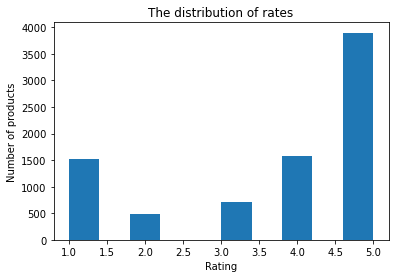

In [232]:
plt.hist(rate_review['rating'])
plt.xlabel('Rating')
plt.ylabel('Number of products')
plt.title('The distribution of rates')
plt.show()

Посмотрим на распределение длин: 

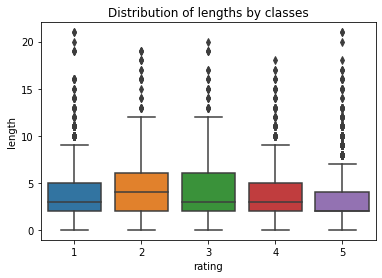

In [233]:
rate_review['length'] = rate_review['review'].str.split().str.len()
sns.boxplot(x='rating', y='length', data=rate_review)
plt.title('Distribution of lengths by classes')
plt.show()

Как мы видим, здесь тоже много выбросов, поэтому посчитаем корреляцию: 

In [234]:
rate_review[['rating', 'length']].corr()

,rating,length
rating,1.000000,-0.155659
length,-0.155659,1.000000


Вероятно, этот признак не будет полезен, поэтому будем основываться только на текстовых данных.


### 2.2 Препроцессинг

Уберем стоп-слова и пунктуацию и приведем все к леммам:

In [235]:
rate_review['lemmas'] = rate_review['review'].apply(preprocessing)

In [236]:
rate_review.head()

,review,rating,length,lemmas
0,Not happy with product,1,4,happy product
1,It's not as expected.,1,4,expect
2,AVERAGE PRODUCT,3,2,average product
3,Pic more beautiful,3,3,pic beautiful
4,Got damage product. But quality is average for...,3,9,get damage product quality average 300


### 2.3 Векторизация

Снова векторизуруем данные:

In [237]:
TRAIN, TEST = train_test_split(rate_review)
y_train = TRAIN['rating']
y_test = TEST['rating']

In [238]:
bow_vector = CountVectorizer()
bow_train = bow_vector.fit_transform(TRAIN['lemmas'])
bow_test = bow_vector.transform(TEST['lemmas'])

In [239]:
tf_vector = TfidfVectorizer()
tf_train = tf_vector.fit_transform(TRAIN['lemmas'])
tf_test = tf_vector.transform(TEST['lemmas'])

### 2.4 Гридсерч

Выберем лучшую модель с лучшими гиперпараметрами из логистической регрессии, RandomForest и SVM (метрика - accuracy):

In [240]:
def gridsearch_cl(estimator, param, vectors):
    clf = GridSearchCV(estimator, param, scoring='accuracy')
    clf.fit(vectors, y_train)
    print(clf.best_estimator_, clf.best_score_)
    return clf

In [241]:
import warnings
warnings.filterwarnings('ignore')

logreg = LogisticRegression()
param = {"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
gr_logreg = gridsearch_cl(logreg, param, bow_train)
gr_logreg_tf = gridsearch_cl(logreg, param, tf_train)

LogisticRegression() 0.606084529030807
LogisticRegression() 0.6013659065801399


In [242]:
cl_tree = RandomForestClassifier()
param = { 
    'n_estimators': [200, 400],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
gr_tr = gridsearch_cl(cl_tree, param, bow_train)
gr_tr_tf = gridsearch_cl(cl_tree, param, tf_train)

RandomForestClassifier(max_depth=8, max_features='sqrt', n_estimators=200) 0.48584466186403114
RandomForestClassifier(max_depth=8, n_estimators=400) 0.4843799241898033


In [243]:
svc = SVC()
param = {'kernel':('linear', 'rbf'), 'C':[1, 10]}

gr_svc = gridsearch_cl(svc, param, bow_train)
gr_svc_tf = gridsearch_cl(svc, param, tf_train)

SVC(C=1) 0.6062472629608313
SVC(C=1) 0.6083625394431323


In [244]:
cl_bow = compare(gr_logreg, gr_tr, gr_svc)
cl_tf = compare(gr_logreg_tf, gr_tr_tf, gr_svc_tf)

print('Лучшая модель для BOW:', cl_bow)
print('Лучшая модель для TF-IDF:', cl_tf)

Лучшая модель для BOW: SVC(C=1)
Лучшая модель для TF-IDF: SVC(C=1)


SVM оказался лучше логистической регрессии, так как он выбирает классификатор с лучшим разграничением классов. Вероятно, из-за того, что признаки плохо интерпретируемы, то RandomForest плохо по ним делит

### 2.5 Анализ лучших моделей

In [245]:
cl_bow_pred = cl_bow_pred(t)
cl_tf_pred = cl_tf.predict(tf_test)
print('Accuracy для BoW-модели равен:', accuracy_score(y_test, cl_bow_pred))
print('Accuracy для TfIdf-модели равен:', accuracy_score(y_test, cl_tf_pred))

Accuracy для BoW-модели равен: 0.3933626159102001
Accuracy для TfIdf-модели равен: 0.4011713030746706


Качество даже лучших моделей оказывается достаточно плохим, мы бы назвали хорошим качество больше 0.7

In [246]:
print('Метрики для BoW-модели:')
print(classification_report(y_test, cl_tf_pred))

Метрики для BoW-модели:
              precision    recall  f1-score   support

           1       0.22      0.18      0.20       396
           2       0.00      0.00      0.00       126
           3       0.05      0.02      0.03       174
           4       0.14      0.03      0.05       399
           5       0.46      0.75      0.57       954

    accuracy                           0.39      2049
   macro avg       0.18      0.20      0.17      2049
weighted avg       0.29      0.39      0.32      2049



In [247]:
print('Метрики для TfIdf-модели:')
print(classification_report(y_test, cl_bow_pred))

Метрики для TfIdf-модели:
              precision    recall  f1-score   support

           1       0.21      0.16      0.18       396
           2       0.00      0.00      0.00       126
           3       0.05      0.02      0.03       174
           4       0.12      0.02      0.03       399
           5       0.46      0.78      0.58       954

    accuracy                           0.40      2049
   macro avg       0.17      0.20      0.17      2049
weighted avg       0.28      0.40      0.32      2049



Как видно из метрик для каждого класса, проблемы моделей появляются из-за дисбаланса классов в датасете, и модели показывают плохое качество для второго, третьего и четвертого класса.

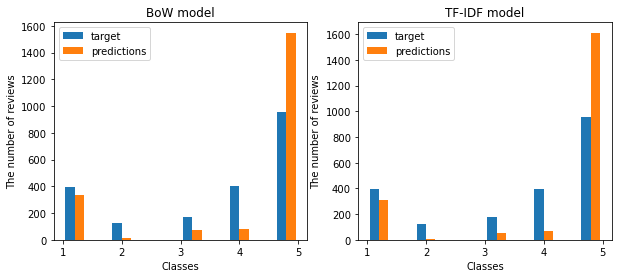

In [248]:
figure, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist([y_test,cl_tf_pred], label=['target', 'predictions'])
ax[0].set_xlabel('Classes')
ax[0].set_ylabel('The number of reviews')
ax[0].set_title('BoW model')
ax[0].legend(loc='upper left')
ax[1].hist([y_test,cl_bow_pred], label=['target', 'predictions'])
ax[1].set_xlabel('Classes')
ax[1].set_ylabel('The number of reviews')
ax[1].set_title('TF-IDF model')
ax[1].legend(loc='upper left')
fig.suptitle('Distribution of target vs predicted values')
plt.show()

Как мы видим, модели почти не предсказывают второй и третий класс, так как их достаточно мало среди настоящих значений. Четвертый класс, который среди настоящих значений, такой же частотный, как и первый, не предсказывается моделями.

Построим confusion matrix, чтобы посмотреть, какие классы чаще всего путаются:

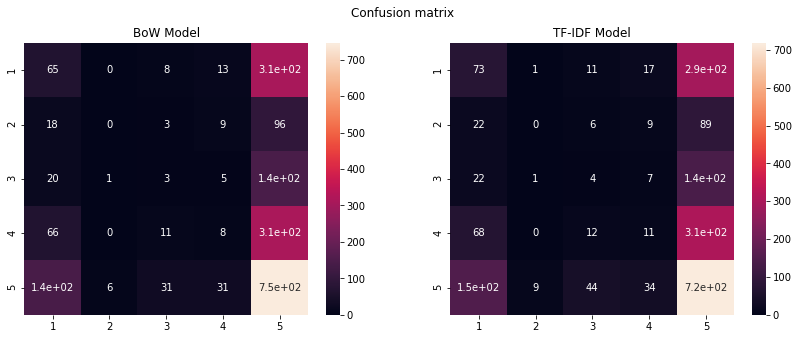

In [249]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
bow_matrix = confusion_matrix(y_test, cl_bow_pred)
tf_matrix = confusion_matrix(y_test, cl_tf_pred)
sns.heatmap(ax=ax[0], data=bow_matrix, annot=True, xticklabels=range(1, 6), yticklabels=range(1, 6))
ax[0].set_title('BoW Model')
sns.heatmap(ax=ax[1], data=tf_matrix, annot=True, xticklabels=range(1, 6), yticklabels=range(1, 6))
ax[1].set_title('TF-IDF Model')
fig.suptitle('Confusion matrix')
plt.show()

Из-за того, что 5 класса больше всего, как мы видели на графике распределения отзывов, то модели часто путают его с этим классом. Однако они выучили какие-то черты первого класса, так как правильно его определяют. 
Вероятно, четвертый класс так часто путается с пятым, так как они обладают похожими чертами, а объектов пятого класса гораздо больше.

К сожалению, sklearn не дает получать веса признаков для моделей с ядром kernel, поэтому не получается узнать, какие слова оказываются важными для тех или иных классов и моделей.